In [ ]:
!pip install pandas
!pip install pillow
!pip install kagglehub
!pip install scikit-learn
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip install timm
!pip install onnx
!pip install onnxruntime
!pip install albumentations

In [ ]:
import huggingface_hub
huggingface_hub.login()

In [3]:
import os
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score
from PIL import Image
from itertools import combinations
import kagglehub
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.amp import GradScaler, autocast
import timm
from torchvision import models, transforms
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import onnx
import onnxruntime as ort
from onnxruntime.quantization import quantize_dynamic, QuantType
import time
from tqdm import tqdm
from matplotlib import pyplot as plt

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
def create_image_pairs_labels(dataset_dir, num_impostor_pairs=1000):
    # Dictionary to organize images by user and finger type
    user_finger_dict = {}

    # Step 1: Parse filenames and organize by user ID and finger type
    for filename in os.listdir(dataset_dir):
        if filename.endswith(".BMP"):
            parts = filename.split("__")  # Splitting by double underscore
            user_num = parts[0]
            finger_type = parts[1].rsplit("_", 1)[0]  # Extracting finger info without augmentation part

            # Add to dictionary
            if (user_num, finger_type) not in user_finger_dict:
                user_finger_dict[(user_num, finger_type)] = []
            user_finger_dict[(user_num, finger_type)].append(os.path.join(dataset_dir, filename))

    image_pairs = []
    labels = []

    # Step 2: Create genuine pairs (same user, same finger)
    for _, images in user_finger_dict.items():
        if len(images) > 1:
            for img1, img2 in combinations(images, 2):
                image_pairs.append((img1, img2))
                labels.append(1)  # 1 for genuine pairs

    # Step 3: Create impostor pairs (different user or different finger)
    user_finger_keys = list(user_finger_dict.keys())
    num_pairs = 0

    while num_pairs < num_impostor_pairs:
        user_finger1, user_finger2 = random.sample(user_finger_keys, 2)

        # Ensure different user or finger type
        if user_finger1[0] != user_finger2[0] or user_finger1[1] != user_finger2[1]
            img1 = random.choice(user_finger_dict[user_finger1])
            img2 = random.choice(user_finger_dict[user_finger2])
            image_pairs.append((img1, img2))
            labels.append(-1)  # -1 for impostor pairs
            num_pairs += 1

    return image_pairs, labels

In [ ]:
class Transforms:
    def __init__(self, augmentation=True):
        # Define augmentation transforms (Albumentations)
        self.augmentation_transforms = A.Compose([
            A.RandomBrightnessContrast(p=0.2),
            # Flipping to account for possible orientation changes
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            # Gaussian blur to simulate minor blurring in fingerprints
            A.GaussianBlur(blur_limit=(3, 7), p=0.3),
            # Crop and resize to the original transformer input size
            A.RandomResizedCrop(height=244, width=244, scale=(0.8, 1.0), p=0.5),
            # Shift, scale, and rotate to account for finger misplacement
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5),
            # Random occlusion to simulate partial visibility of fingerprints
            A.CoarseDropout(max_holes=5, max_height=20, max_width=20, min_holes=1, min_height=10, min_width=10, fill_value=0, p=0.4),

        ]) if augmentation else None

        # Define resize and normalization (Albumentations and PyTorch)
        self.resize_and_normalize = A.Compose([
            A.Resize(224, 224),  # Resizing to 224x224
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
            ToTensorV2()  # Convert to PyTorch tensor
        ])

    def __call__(self, img):
        # Convert PIL Image to numpy array if necessary
        if isinstance(img, Image.Image):
            img = np.array(img)

        # Apply augmentation transforms if enabled
        if self.augmentation_transforms:
            img = self.augmentation_transforms(image=img)["image"]

        # Apply resize and normalize transforms
        img = self.resize_and_normalize(image=img)["image"]

        return img

In [ ]:
# Custom Dataset for Siamese Network
class SiameseFingerprintDataset(Dataset):
    def __init__(self, image_pairs, labels, transform=None):
        self.image_pairs = image_pairs
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        # Load images from file paths
        img1_path, img2_path = self.image_pairs[index]
        if not os.path.isfile(img1_path):
            raise FileNotFoundError(f"Image 1 not found: {img1_path}")
        if not os.path.isfile(img2_path):
            raise FileNotFoundError(f"Image 2 not found: {img2_path}")

        img1 = Image.open(img1_path).convert("RGB")  # Ensure 3 channels
        img2 = Image.open(img2_path).convert("RGB")

        # Apply transformations
        img1 = self.transform(img1)
        img2 = self.transform(img2)

        # Get label
        label = torch.tensor(self.labels[index], dtype=torch.float32)

        return img1, img2, label

    def __len__(self):
        return len(self.image_pairs)

In [ ]:
class SiameseDeiTTiny(nn.Module):
    def __init__(self, embedding = 64):
        super(SiameseDeiTTiny, self).__init__()
        self.deit = timm.create_model('deit_tiny_patch16_224', pretrained=True)

        # Get the number of features from the previous layer
        num_features = self.deit.head.in_features

        # Remove the original classification head
        self.deit.head = None

        # Add a new fully connected layer with the desired embedding dimension
        self.deit.head = nn.Linear(num_features, embedding)

    def forward(self, img1, img2):
        embed1 = self.deit(img1)
        embed2 = self.deit(img2)
        return embed1, embed2

In [ ]:
# Mapper function to return the corresponding distance metric function
def get_distance_metric_function(distance_metric):
    """
    Returns the appropriate distance metric function based on the string input.

    :param distance_metric: One of ['euclidean', 'cosine', 'manhattan', 'mahalanobis', 'dot', 'squared_euclidean']
    :return: Corresponding distance metric function
    """
    if distance_metric == 'euclidean':
        return euclidean_distance
    elif distance_metric == 'cosine':
        return cosine_similarity
    elif distance_metric == 'manhattan':
        return manhattan_distance
    elif distance_metric == 'mahalanobis':
        return mahalanobis_distance
    elif distance_metric == 'dot':
        return dot_product
    elif distance_metric == 'squared_euclidean':
        return squared_euclidean_distance
    else:
        raise ValueError(f"Unknown distance metric: {distance_metric}")

# Define individual distance functions
def euclidean_distance(output1, output2):
    return F.pairwise_distance(output1, output2, keepdim=True)

def cosine_similarity(output1, output2):
    return 1 - F.cosine_similarity(output1, output2)

def manhattan_distance(output1, output2):
    return torch.sum(torch.abs(output1 - output2), dim=1, keepdim=True)

def mahalanobis_distance(output1, output2):
    diff = output1 - output2
    return torch.sqrt(torch.sum(torch.pow(diff, 2), dim=1, keepdim=True))

def dot_product(output1, output2):
    return torch.sum(output1 * output2, dim=1, keepdim=True)

def squared_euclidean_distance(output1, output2):
    return torch.sum(torch.pow(output1 - output2, 2), dim=1, keepdim=True)


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0, distance_metric_fn=None):
        """
        Constructor for ContrastiveLoss.

        :param margin: Margin for Contrastive Loss. Default is 1.0.
        :param distance_metric_fn: A function for distance metric (e.g., euclidean_distance, cosine_similarity, etc.)
        """
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.distance_metric_fn = distance_metric_fn

    def forward(self, output1, output2, label):
        # Calculate distance using the passed distance metric function
        distance = self.distance_metric_fn(output1, output2)

        # Compute contrastive loss
        loss = torch.mean((label == 1) * torch.pow(distance, 2) +
                          (label == -1) * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))

        return loss

In [ ]:
# Evaluation Function
def calculate_far_frr(predictions, labels):
    # Convert inputs to numpy arrays for easier boolean indexing
    predictions = np.array(predictions)
    labels = np.array(labels)

    # Calculate True Positives, False Positives, True Negatives, and False Negatives
    true_positives = ((predictions == 1) & (labels == 1)).sum()  # Genuine pairs correctly identified
    false_positives = ((predictions == 1) & (labels == -1)).sum()  # Imposter pairs incorrectly identified as genuine
    true_negatives = ((predictions == -1) & (labels == -1)).sum()  # Imposter pairs correctly identified
    false_negatives = ((predictions == -1) & (labels == 1)).sum()  # Genuine pairs incorrectly identified as imposter

    # Calculate FAR and FRR
    far = false_positives / (false_positives + true_negatives) if (false_positives + true_negatives) > 0 else 0
    frr = false_negatives / (false_negatives + true_positives) if (false_negatives + true_positives) > 0 else 0

    return far, frr

In [ ]:
# Training Function
def train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5):
    model.train()

    # Initialize variables for early stopping
    best_val_loss = float('inf')
    patience_counter = 0

    # GradScaler for mixed precision training
    scaler = GradScaler()

    for epoch in tqdm(range(num_epochs), desc='Epoch: '):
        model.train()  # Set model to training mode
        total_train_loss = 0.0

        # Training loop
        for img1, img2, label in train_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            optimizer.zero_grad()

            # Forward pass with mixed precision
            with autocast(device_type='cuda', dtype=torch.float16):
                embed1, embed2 = model(img1, img2)
                loss = criterion(embed1, embed2, label.float())

            # Backward pass and optimization
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        total_val_loss = 0.0
        with torch.no_grad():
            for img1, img2, label in val_loader:
                img1, img2, label = img1.to(device), img2.to(device), label.to(device)

                # Forward pass
                with autocast(device_type='cuda', dtype=torch.float16):
                    embed1, embed2 = model(img1, img2)
                    val_loss = criterion(embed1, embed2, label.float())
                    total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save the best model state
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        # If the patience counter exceeds the patience threshold, stop training
        if patience_counter >= patience:
            print("Early stopping triggered. Restoring best model state.")
            model.load_state_dict(best_model_state)
            break

    return model

# Testing Function
def test_model(model, test_loader, device, distance_metric_fn=None):
    model.eval()
    embeddings1 = []
    embeddings2 = []
    labels = []

    with torch.no_grad():
        for img1, img2, label in  test_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            embed1, embed2 = model(img1, img2)
            embeddings1.append(embed1)
            embeddings2.append(embed2)
            labels.extend(label.cpu().numpy())

    embeddings1 = torch.cat(embeddings1)
    embeddings2 = torch.cat(embeddings2)

    similarities = distance_metric_fn(embeddings1, embeddings2)

    return labels, similarities

def evaluate_result(labels, similarities, threshold):
    # Label the predicted cosine similarity depending on the threshold
    predictions = np.where(similarities.cpu().numpy() <= threshold, 1, -1)

    accuracy = accuracy_score(labels, predictions)
    far, frr = calculate_far_frr(predictions, labels)

    return accuracy, far, frr

### Kaggle 데이터셋 다운로드 및 경로 설정

In [ ]:
# Download latest version
path = kagglehub.dataset_download("ruizgara/socofing")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ruizgara/socofing/versions/2


In [ ]:
path_easy = os.path.join(path, 'SOCOFing/Altered/Altered-Easy')
path_medium = os.path.join(path, 'SOCOFing/Altered/Altered-Medium')
path_hard = os.path.join(path, 'SOCOFing/Altered/Altered-Hard')

### 이미지 쌍 생성

In [ ]:
# Prepare dataset
hard_image_pairs, hard_labels = create_image_pairs_labels(path_hard, num_impostor_pairs=30000)
medium_image_pairs, medium_labels = create_image_pairs_labels(path_medium, num_impostor_pairs=30000)
easy_image_pairs, easy_labels = create_image_pairs_labels(path_easy, num_impostor_pairs=30000)

In [ ]:
image_pairs = hard_image_pairs + medium_image_pairs + easy_image_pairs
labels = hard_labels + medium_labels + easy_labels

combined = list(zip(image_pairs, labels))

# Shuffle the combined array
np.random.shuffle(combined)

# Unzip the shuffled array back into image pairs and labels
image_pairs, labels = zip(*combined)

In [ ]:
# Initial split: 80% for training/validation and 20% for testing
train_val_size = int(0.8 * len(image_pairs))
test_size = len(image_pairs) - train_val_size

train_val_image_pairs, test_image_pairs = image_pairs[:train_val_size], image_pairs[train_val_size:]
train_val_labels, test_labels = labels[:train_val_size], labels[train_val_size:]

# Further split the training/validation set into 90% training and 10% validation
train_size = int(0.9 * len(train_val_image_pairs))
val_size = len(train_val_image_pairs) - train_size

train_image_pairs, val_image_pairs = train_val_image_pairs[:train_size], train_val_image_pairs[train_size:]
train_labels, val_labels = train_val_labels[:train_size], train_val_labels[train_size:]

In [ ]:
batch_size = 64

# Create datasets
train_dataset = SiameseFingerprintDataset(train_image_pairs, train_labels, Transforms(augmentation=True))
val_dataset = SiameseFingerprintDataset(val_image_pairs, val_labels, Transforms(augmentation=False))
test_dataset = SiameseFingerprintDataset(test_image_pairs, test_labels, Transforms(augmentation=False))

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)


### 모델 학습

In [ ]:
# Learning
num_epochs = 300
patience = 10
learning_rate = 1e-4

# Loss function
margin = 1.2
distance_metric = 'cosine' # distance_metric = ['euclidean', 'cosine', 'manhattan', 'mahalanobis', 'dot', 'squared_euclidean']
distance_fn = get_distance_metric_function(distance_metric)

In [ ]:
 # Initialize Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseDeiTTiny().to(device)
criterion = ContrastiveLoss(margin=margin, distance_metric_fn=distance_fn)
#criterion = nn.CosineEmbeddingLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train the model
print("Starting Training...")
model = train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs)
torch.save(model, 'model_cr_loss_mahalanobis.pt')

### 모델 테스트

In [ ]:
# Test the model
print("Testing the model...")
model = torch.load('model_cr_loss_cosine.pt', map_location=device, weights_only=False)
labels, similarities = test_model(model, test_loader, device, distance_metric_fn=distance_fn)

Testing the model...


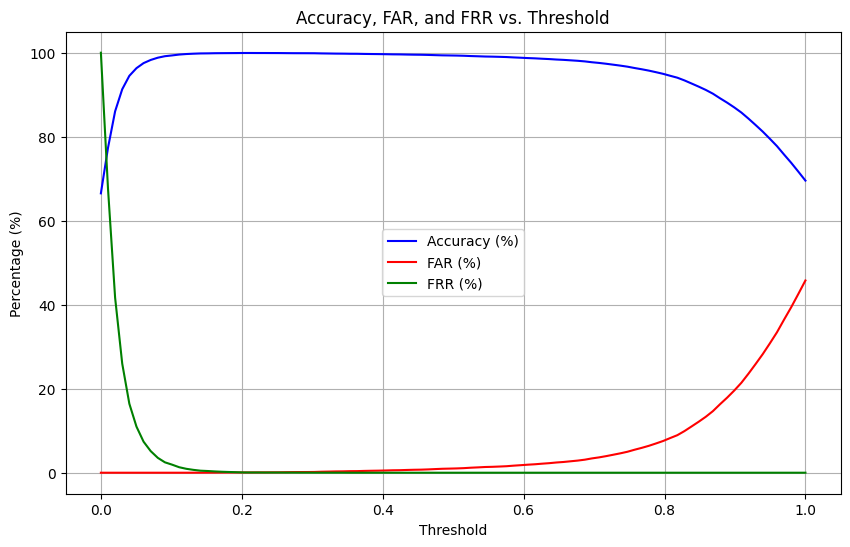

In [ ]:
# Define a range of thresholds to test
thresholds = np.linspace(0, 1, 100)  # Adjust the range and step size as needed

# Lists to store the metrics for each threshold
accuracies = []
fars = []
frrs = []

# Loop through each threshold, calculate metrics, and store the results
max_accuracy = 0
best_threshold = 0
for threshold in thresholds:
    accuracy, far, frr = evaluate_result(labels, similarities, threshold)
    accuracies.append(accuracy)
    fars.append(far)
    frrs.append(frr)

    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_threshold = threshold

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, np.array(accuracies) * 100, label="Accuracy (%)", color="blue")
plt.plot(thresholds, np.array(fars) * 100, label="FAR (%)", color="red")
plt.plot(thresholds, np.array(frrs) * 100, label="FRR (%)", color="green")

# Adding labels and legend
plt.xlabel("Threshold")
plt.ylabel("Percentage (%)")
plt.title("Accuracy, FAR, and FRR vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
accuracy, far, frr = evaluate_result(labels, similarities, best_threshold)

print(f"Best threshold: {best_threshold}")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"FAR: {far * 100:.2f}%")
print(f"FRR: {frr * 100:.2f}%")

Best threshold: 0.20202020202020204
Accuracy: 99.94%
FAR: 0.06%
FRR: 0.07%


### 모델 ONNX 변환

In [ ]:
model.eval()
input_shape = (1, 3, 224, 224)  # Example input shape for the model
dummy_input1 = torch.randn(input_shape).to(device)
dummy_input2 = torch.randn(input_shape).to(device)

onnx_model_path = "deit_tiny_siamese.onnx"  # Specify the path for the ONNX model

# Export the model
torch.onnx.export(
    model,
    (dummy_input1, dummy_input2),
    onnx_model_path,
    opset_version=14,
    input_names=["input1", "input2"],
    output_names=["output1", "output2"],
)

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:2041: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


In [ ]:
# Load the ONNX model
onnx_model = onnx.load("deit_tiny_siamese.onnx")

# Get the output shape from the model
output_shape = onnx_model.graph.output[0].type.tensor_type.shape.dim

# Calculate the size of a single element in KB (assuming float32)
element_size_kb = 4 / 1024

# Calculate the total size of the output embedding in KB
output_size_kb = 1
for dim in output_shape:
    if hasattr(dim, 'dim_value'):
        output_size_kb *= dim.dim_value
output_size_kb *= element_size_kb

print(f"Output embedding size: {output_size_kb:.2f} KB")

Output embedding size: 0.25 KB


In [ ]:
# Example input shape
input_shape = (1, 3, 224, 224)

# Optimization Options:
options = ort.SessionOptions()
options.optimized_model_filepath = "optimized_deit_tiny_siamese.onnx"
options.execution_mode = ort.ExecutionMode.ORT_SEQUENTIAL
options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
options.enable_cpu_mem_arena = True
options.enable_mem_pattern = True

ort_session = ort.InferenceSession("deit_tiny_siamese.onnx",
                                   sess_options=options)

# Benchmarking:
num_runs = 100  # Number of runs for benchmarking
dummy_input1 = torch.randn(input_shape).numpy()  # Example input
dummy_input2 = torch.randn(input_shape).numpy()

# Warm-up run
ort_session.run(None, {"input1": dummy_input1, "input2": dummy_input2})

# Measure inference time
start_time = time.time()
for _ in range(num_runs):
    ort_session.run(None, {"input1": dummy_input1, "input2": dummy_input2})
end_time = time.time()

# Calculate and print average inference time
avg_inference_time = (end_time - start_time) / num_runs
print(f"Average Inference Time (ONNX Runtime): {avg_inference_time:.4f} seconds")

Average Inference Time (ONNX Runtime): 0.0619 seconds


In [ ]:
def run_inference_onnx(img1, img2):
    # Ensure the inputs are on the correct device and have the correct shape
    img1 = img1.cpu().numpy() if isinstance(img1, torch.Tensor) else img1
    img2 = img2.cpu().numpy() if isinstance(img2, torch.Tensor) else img2

    # Run inference using ONNX Runtime
    ort_inputs = {"input1": img1, "input2": img2}
    ort_outs = ort_session.run(None, ort_inputs)

    return ort_outs

def evaluate_onnx_model(test_loader, threshold, distance_metric_fn):
    onnx_predictions = []
    labels = []

    for img1, img2, label in tqdm(test_loader, desc="Evaluating ONNX Model"):
        img1, img2 = img1.to(device), img2.to(device)

        # ONNX inference
        ort_outs = run_inference_onnx(img1, img2)
        onnx_similarity = distance_metric_fn(torch.tensor(ort_outs[0]), torch.tensor(ort_outs[1]))

        # Apply threshold
        onnx_prediction = 1 if onnx_similarity.cpu().numpy() <= threshold else -1
        onnx_predictions.append(onnx_prediction)
        labels.append(label.item())

    onnx_accuracy = accuracy_score(labels, onnx_predictions)
    return onnx_accuracy

# Evaluate ONNX model
onnx_accuracy = evaluate_onnx_model(test_loader, best_threshold, distance_fn)
print(f"ONNX Accuracy: {onnx_accuracy * 100:.2f}%")

Evaluating ONNX Model: 100%|██████████| 27167/27167 [21:49<00:00, 20.75it/s]


ONNX Accuracy: 99.94%
